# Distribution of BIRs in a dynamic network

The aim of this notebook is to test the behavior of the algorithm observing the distribution of BIRs in a dynamic directed network.  
We will generate the starting synthetic network using the built-in graph generators of NetworkX package: https://networkx.org/documentation/stable/reference/generators.html

In [2]:
import random
from types import SimpleNamespace
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import sys
sys.path.insert(1, '../python/src')

import BIRs

Prepare base constants

In [3]:
# Set base variables
levels_enum = ['top', 'strong', 'weak', 'branch', 'none']
roles_enum = ['emitter', 'amplifier', 'hub', 'reducer', 'receiver', 'isolated']
colors_enum = ['#3d8043', '#81b622', '#0e86d4', '#ffa500', '#d10000', '#282828']
level_colors = ['#d7301f', '#fc8d59', '#fdcc8a', '#FFA500', '#888']
role_colors = {r: colors_enum[i] for i, r in enumerate(roles_enum)}

Prepare some helper functions

In [5]:
def getBIRsFrequencies(G):
    """Get BIRs frequencies given a network dataset"""
    # Remove possible self-loop edges
    G.remove_edges_from(nx.selfloop_edges(G))
    # Get basic influence roles
    roles = BIRs.detect_nx(G)
    # Calculate distributions
    distribution = BIRs.distribution(roles)
    # Prepare frequency data
    frequency = [dict(role=k, freq=v['frequency']) for k, v in distribution.items()]
    frequency.sort(key=lambda v: v['freq'], reverse=True)
    # Prepare frequency data of role's levels
    frequency_levels = [
        dict(role=k, level=kl, freq=vl['frequency'])
        for k, v in distribution.items()
        for kl, vl in v['levels'].items()
    ]
    frequency_levels.sort(key=lambda v: v['freq'], reverse=True)
    return roles, frequency, frequency_levels

def plotHeatmap(rows, xlabels=[], ylabels=[], figsize=(8,2), filename=None):
    """Plot heatmap"""
    sns.set_theme(context='paper')
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(
        np.around(np.array(rows), decimals=2),
        cmap="YlGnBu",
        annot=True,
        annot_kws={"size": 8},
        xticklabels=xlabels,
        yticklabels=ylabels,
        vmin=0, vmax=1,
        ax=ax
    )
    ax.xaxis.tick_top()
    ax.tick_params(left=False, top=False, bottom=False, right=False)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(size=0, labelsize=8)
    cbar.ax.margins(x=0, y=0, tight=True)
    ax.margins(x=0, y=0, tight=True)
    if filename: plt.savefig(filename, format="pdf", bbox_inches="tight", pad_inches=0)
    plt.show()

def plotTimeline(x, y, label='', filename=None):
    # Plot the timeseries line
    sns.set_theme(context='paper', style="white", palette="tab10")
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.bar(x, y)
    for i in range(len(x)):
        ax.text(i, y[i]+10, y[i], ha='center', fontdict={'size': 8})
    ax.margins(x=0, y=0, tight=True)
    ax.get_yaxis().set_ticks([])
    for i in ('top', 'right', 'bottom', 'left'): ax.spines[i].set_visible(False)
    if label: ax.set_ylabel(label)
    if filename: plt.savefig(filename, format="pdf", bbox_inches="tight", pad_inches=0, dpi=40)
    # Show the plot
    plt.tight_layout()
    plt.show()

The dataset will be generated using an Independent Cascade Model to simulate a temporal network with evolving interactions.

In [6]:
def prepareSnapshot(G):
    """Prepare snapshot data"""
    roles, frequency, frequency_levels = getBIRsFrequencies(G)
    return SimpleNamespace(
        nodes=G.number_of_nodes(),
        edges=G.number_of_edges(),
        frequency=frequency,
        frequency_levels=frequency_levels
    )

def createDynamicNetwork(n=100, add_probability=0.2, remove_probabilities=[0.1], seed=None):
    """Simulates a dynamic network by adding and removing edges over time steps."""
    G = nx.erdos_renyi_graph(n, 0.01, seed=seed, directed=True)
    G.remove_edges_from(nx.selfloop_edges(G))
    network_snapshots = [prepareSnapshot(G)]
    random.seed(seed)
    # For each time step
    for remove_prob in remove_probabilities:
        # Add new edges
        for i in G.nodes():
            for j in G.nodes():
                if i != j and not G.has_edge(i, j) and random.random() < add_probability:
                    G.add_edge(i, j)
        # Remove existing edges
        for edge in list(G.edges()):
            if random.random() < remove_prob:
                G.remove_edge(*edge)
        # Store graph snapshot
        network_snapshots.append(prepareSnapshot(G))
    # Return all graph snapshots
    return network_snapshots


### Dynamic Network

Now we will generate the dynamic network.

In [7]:
snapshots = createDynamicNetwork(
    n=100,
    add_probability=0.2,
    remove_probabilities=[0.4, 0.5, 0.7, 0.9, 0.94, 0.96, 0.7, 0.9, 0.9, 0.94, 0.99],
    seed=268451
)

# Access and analyze the network at each time step
for i, snapshot in enumerate(snapshots):
    print(f"Network at step {i+1}:")
    print(f"  Nodes: {snapshot.nodes}")
    print(f"  Edges: {snapshot.edges}")
    print(f"  Roles: {snapshot.frequency}")

Network at step 1:
  Nodes: 100
  Edges: 103
  Roles: [{'role': 'emitter', 'freq': 0.28}, {'role': 'receiver', 'freq': 0.24}, {'role': 'hub', 'freq': 0.14}, {'role': 'amplifier', 'freq': 0.13}, {'role': 'reducer', 'freq': 0.12}, {'role': 'isolated', 'freq': 0.09}]
Network at step 2:
  Nodes: 100
  Edges: 1168
  Roles: [{'role': 'hub', 'freq': 0.53}, {'role': 'amplifier', 'freq': 0.25}, {'role': 'reducer', 'freq': 0.22}]
Network at step 3:
  Nodes: 100
  Edges: 1459
  Roles: [{'role': 'hub', 'freq': 0.62}, {'role': 'reducer', 'freq': 0.2}, {'role': 'amplifier', 'freq': 0.18}]
Network at step 4:
  Nodes: 100
  Edges: 930
  Roles: [{'role': 'hub', 'freq': 0.62}, {'role': 'amplifier', 'freq': 0.2}, {'role': 'reducer', 'freq': 0.18}]
Network at step 5:
  Nodes: 100
  Edges: 266
  Roles: [{'role': 'amplifier', 'freq': 0.32}, {'role': 'reducer', 'freq': 0.28}, {'role': 'hub', 'freq': 0.27}, {'role': 'receiver', 'freq': 0.07}, {'role': 'emitter', 'freq': 0.06}]
Network at step 6:
  Nodes: 100


### Results

Here the results for every time step.

In [8]:
df = pd.DataFrame([{r['role']: r['freq'] for r in s.frequency} for s in snapshots]).fillna(0).reindex(roles_enum, axis=1)
df

,emitter,amplifier,hub,reducer,receiver,isolated
0,0.28,0.13,0.14,0.12,0.24,0.09
1,0.00,0.25,0.53,0.22,0.00,0.00
2,0.00,0.18,0.62,0.20,0.00,0.00
3,0.00,0.20,0.62,0.18,0.00,0.00
4,0.06,0.32,0.27,0.28,0.07,0.00
5,0.21,0.15,0.23,0.15,0.19,0.07
6,0.24,0.08,0.17,0.08,0.19,0.24
7,0.00,0.28,0.43,0.29,0.00,0.00
8,0.06,0.36,0.23,0.27,0.07,0.01
9,0.15,0.21,0.24,0.31,0.09,0.00


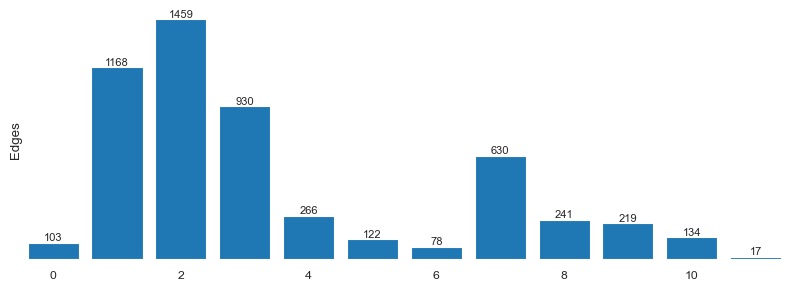

In [9]:
time_steps = [i for i, _ in enumerate(snapshots)]
edges_by_time = [s.edges for s in snapshots]
plotTimeline(time_steps, edges_by_time, label='Edges')

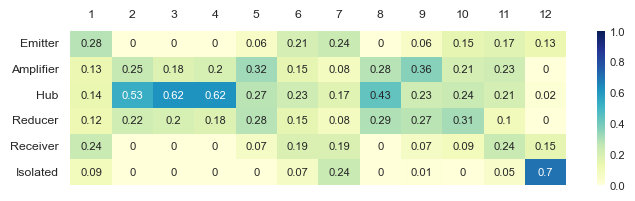

In [10]:
cols = df.index+1
rows = df[roles_enum].transpose().to_numpy()
plotHeatmap(rows, xlabels=cols, ylabels=[r.title() for r in roles_enum])